Gradient Boosting Regrssor model is creating in this code to predict stocks target rates for future. GB model uses desicion trees.

In [1]:
# pip install SQLAlchemy psycopg2

In [2]:
# Importing dependencies
import yfinance as yf
import json
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import datetime
from datetime import datetime
import seaborn as sns
import numpy as np
import sqlalchemy
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")

#  importing credentials for POSTGRES SQL server
from credentials import username, password,hostname,port,database


Creating a Function to iterate through 5 stocks 

In [3]:
# List of stocks
tickers= ['SHOP','KO','MDLZ','AAPL']

In [4]:
# Download historical data for the selected stocks
data = pd.DataFrame(yf.download(tickers, start='2010-01-01', end=datetime.now())['Close'])
data.head()

[*********************100%%**********************]  4 of 4 completed


Ticker,AAPL,KO,MDLZ,SHOP
Date,,,,
2010-01-04,7.643214,28.520000,27.430000,NaN
2010-01-05,7.656429,28.174999,28.770000,NaN
2010-01-06,7.534643,28.165001,28.969999,NaN
2010-01-07,7.520714,28.094999,28.900000,NaN
2010-01-08,7.570714,27.575001,28.930000,NaN


In [5]:
# replacing NA values with zero , shop did not have any value until 2016
data = data.fillna(0)
data.head()

Ticker,AAPL,KO,MDLZ,SHOP
Date,,,,
2010-01-04,7.643214,28.520000,27.430000,0.0
2010-01-05,7.656429,28.174999,28.770000,0.0
2010-01-06,7.534643,28.165001,28.969999,0.0
2010-01-07,7.520714,28.094999,28.900000,0.0
2010-01-08,7.570714,27.575001,28.930000,0.0


In [6]:
#  exporting data to csv file
data.to_csv('Output/stocks_data.csv')

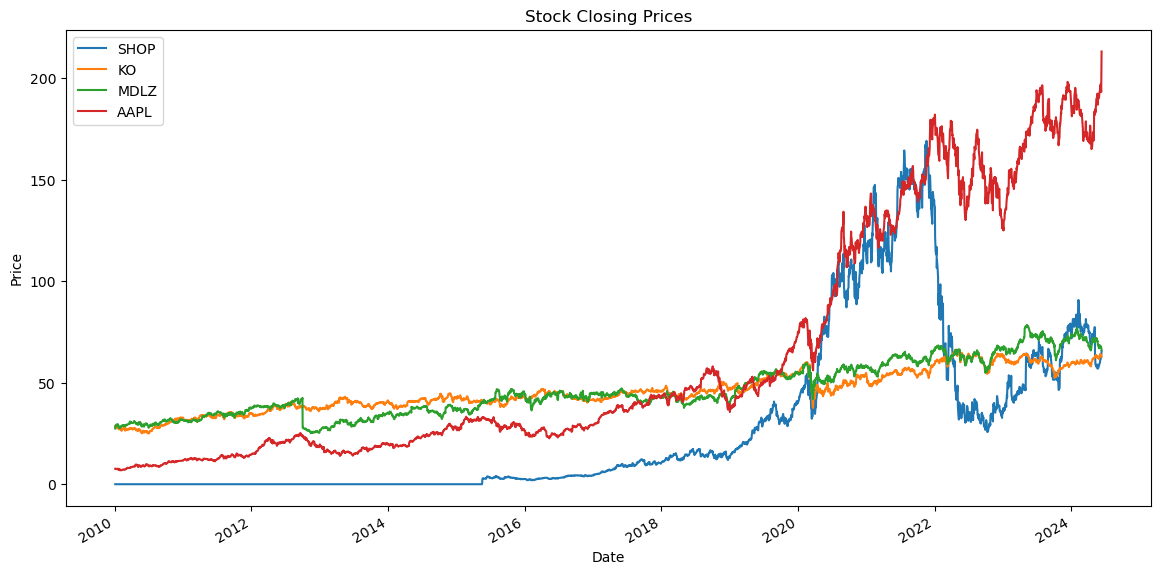

In [7]:
# Plot the closing prices
plt.figure(figsize=(14, 7))
for ticker in tickers:
    data[ticker].plot(label=ticker)
plt.title('Stock Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Above mentioned findings depicts that from 2010 - 2019 there is approx a straight without any curse making it not very relevant for Ml model to learn the trends. So, if we take data from 2010 - 2024 and split by 50/50 it will be a very bad model. So it is better to change the starting point from 2010 to 2020 and split 90/10 so that GBF model can learn and perform better.

In [8]:
# Calculate daily returns
# # Daily Return= 
# Price on Day (t−1)
# Price on Day t−Price on Day (t−1)
# ​
returns = data.pct_change()

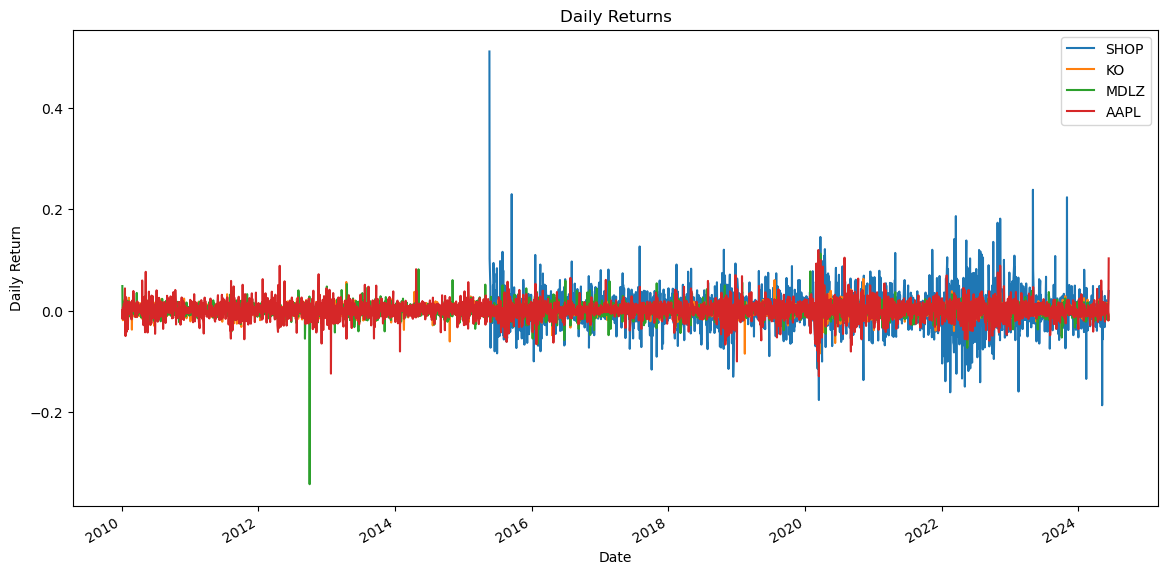

In [9]:
# Plot daily returns
plt.figure(figsize=(14, 7))
for ticker in tickers:
    returns[ticker].plot(label=ticker)
plt.title('Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.show()

In [10]:
# Calculate moving averages
moving_averages = data.rolling(window=30).mean()
moving_averages.dropna()

Ticker,AAPL,KO,MDLZ,SHOP
Date,,,,
2010-02-16,7.275952,27.515167,28.597667,0.000000
2010-02-17,7.262310,27.486667,28.637667,0.000000
2010-02-18,7.248679,27.479333,28.639000,0.000000
2010-02-19,7.237607,27.469167,28.637333,0.000000
2010-02-22,7.225512,27.455667,28.639000,0.000000
...,...,...,...,...
2024-06-05,184.486000,62.561000,70.034334,63.642000
2024-06-06,185.334666,62.647667,69.930334,63.282000
2024-06-07,186.234666,62.720000,69.830667,62.983334


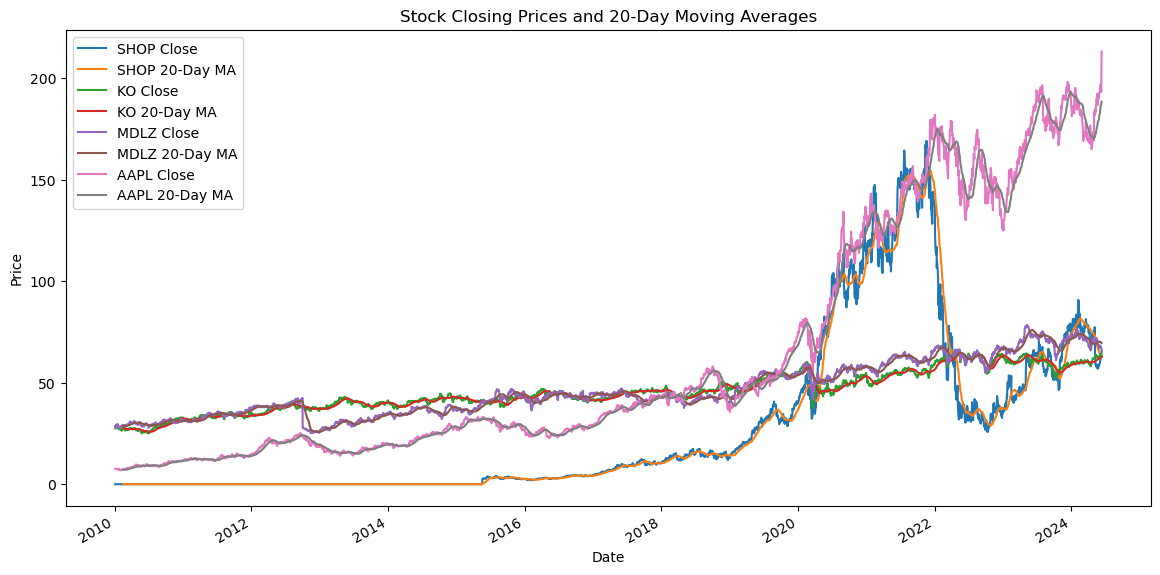

In [11]:
# Plot moving averages
plt.figure(figsize=(14, 7))
for ticker in tickers:
    data[ticker].plot(label=f'{ticker} Close')
    moving_averages[ticker].plot(label=f'{ticker} 20-Day MA')
plt.title('Stock Closing Prices and 20-Day Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

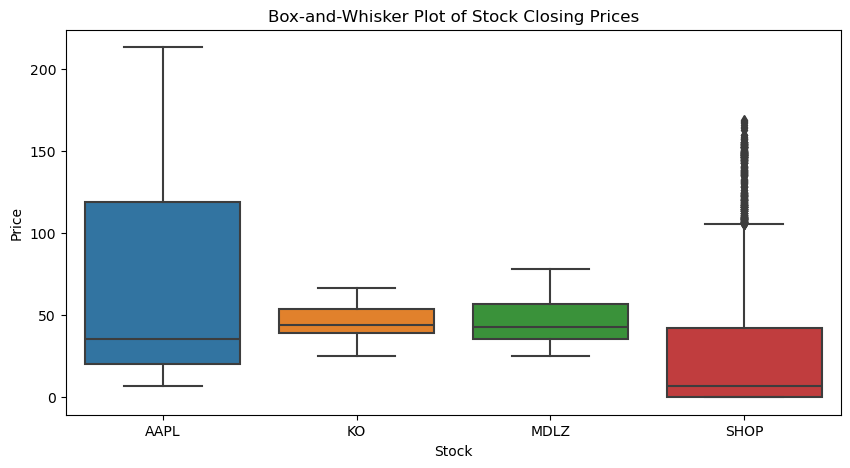

In [12]:
# Create box-and-whisker plots for closing prices
plt.figure(figsize=(10, 5))
sns.boxplot(data=data)
plt.title('Box-and-Whisker Plot of Stock Closing Prices')
plt.xlabel('Stock')
plt.ylabel('Price')
plt.show()

In [13]:
# Database connection to postgres sql server
DATABASE_URL = f"postgresql://{username}:{password}@{hostname}:{port}/{database}"

# Create an engine instance
engine = create_engine(DATABASE_URL)

In [14]:
 # using SQL alchamy   
# sql query 
query = f"""
    SELECT * 
    FROM "Stocks_Data"
    WHERE "Date" >= '2017-01-01' ;
    """
    
# get data from connection
stock_data_df = pd.read_sql(query, engine)
print(stock_data_df)
    
# sorting values
stock_data_df.sort_values(by='Date', inplace=True)
stock_data_df.head()

            Date        AAPL         KO       MDLZ       SHOP
0     2017-01-03   29.037500  41.799999  44.849998   4.282000
1     2017-01-04   29.004999  41.650002  44.799999   4.414000
2     2017-01-05   29.152500  41.750000  45.000000   4.768000
3     2017-01-06   29.477501  41.740002  45.060001   4.690000
4     2017-01-09   29.747499  41.320000  44.689999   4.718000
...          ...         ...        ...        ...        ...
1866  2024-06-04  194.350006  63.939999  68.089996  60.680000
1867  2024-06-05  195.869995  63.919998  67.980003  61.250000
1868  2024-06-06  194.479996  64.150002  68.190002  61.459999
1869  2024-06-07  196.889999  63.910000  67.809998  61.590000
1870  2024-06-10  193.119995  63.590000  67.300003  63.009998

[1871 rows x 5 columns]


,Date,AAPL,KO,MDLZ,SHOP
0,2017-01-03,29.037500,41.799999,44.849998,4.282
1,2017-01-04,29.004999,41.650002,44.799999,4.414
2,2017-01-05,29.152500,41.750000,45.000000,4.768
3,2017-01-06,29.477501,41.740002,45.060001,4.690
4,2017-01-09,29.747499,41.320000,44.689999,4.718


In [15]:
#  setting Date column as index
stock_data_df.set_index('Date',inplace=True)

In [16]:
#  print stock df
stock_data_df

,AAPL,KO,MDLZ,SHOP
Date,,,,
2017-01-03,29.037500,41.799999,44.849998,4.282000
2017-01-04,29.004999,41.650002,44.799999,4.414000
2017-01-05,29.152500,41.750000,45.000000,4.768000
2017-01-06,29.477501,41.740002,45.060001,4.690000
2017-01-09,29.747499,41.320000,44.689999,4.718000
...,...,...,...,...
2024-06-04,194.350006,63.939999,68.089996,60.680000
2024-06-05,195.869995,63.919998,67.980003,61.250000
2024-06-06,194.479996,64.150002,68.190002,61.459999


In [17]:
#  iterate through tickers 
for t in tickers:
    print(t)

SHOP
KO
MDLZ
AAPL


In [18]:
#  checking shape of df 
stock_data_df.shape

(1871, 4)

In [19]:
#  describing df
stock_data_df.describe()

,AAPL,KO,MDLZ,SHOP
count,1871.000000,1871.000000,1871.000000,1871.000000
mean,104.849421,52.804276,56.084030,54.198526
std,55.526681,6.916026,10.455069,42.604001
min,29.004999,37.560001,37.570000,4.282000
25%,47.172501,46.125000,44.900002,15.660000
50%,115.050003,53.220001,56.189999,40.480000
75%,154.504997,59.525000,64.305000,77.850002
max,198.110001,66.209999,78.360001,169.059998


In [20]:
#  testing
for ticker in stock_data_df.columns:
    stock_data= stock_data_df[ticker]

In [21]:
#  testing the data before creating a function for Ml model
ticker= 'SHOP'
stock_data= stock_data_df[ticker]
print(stock_data)

Date
2017-01-03     4.282000
2017-01-04     4.414000
2017-01-05     4.768000
2017-01-06     4.690000
2017-01-09     4.718000
                ...    
2024-06-04    60.680000
2024-06-05    61.250000
2024-06-06    61.459999
2024-06-07    61.590000
2024-06-10    63.009998
Name: SHOP, Length: 1871, dtype: float64


SHOP Mean Squared Error: 6.781056565224966
SHOP Root Mean Squared Error: 2.604046191069768


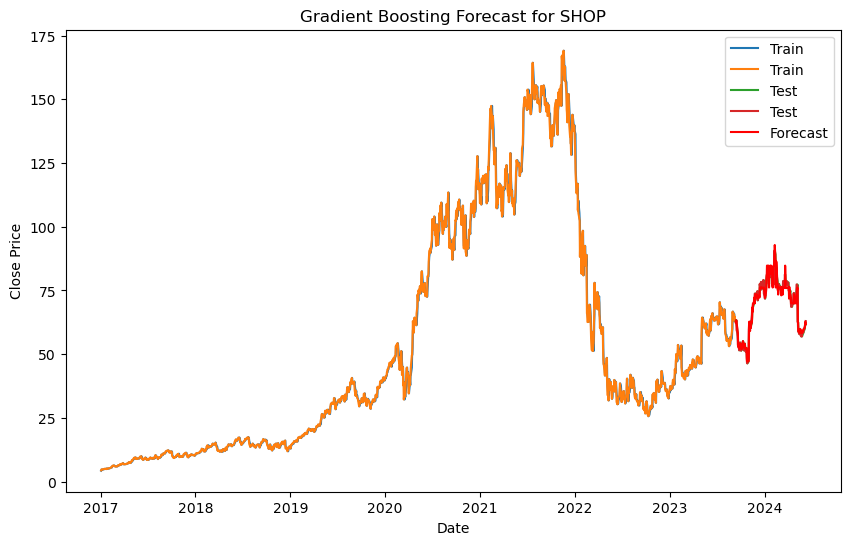

KO Mean Squared Error: 0.29012109870590036
KO Root Mean Squared Error: 0.5386289063036818


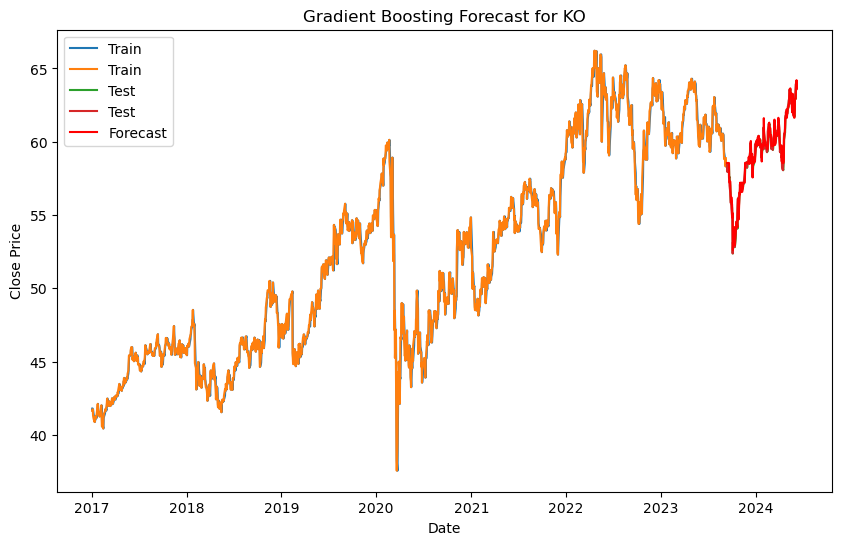

MDLZ Mean Squared Error: 0.7842193656394982
MDLZ Root Mean Squared Error: 0.8855616103013376


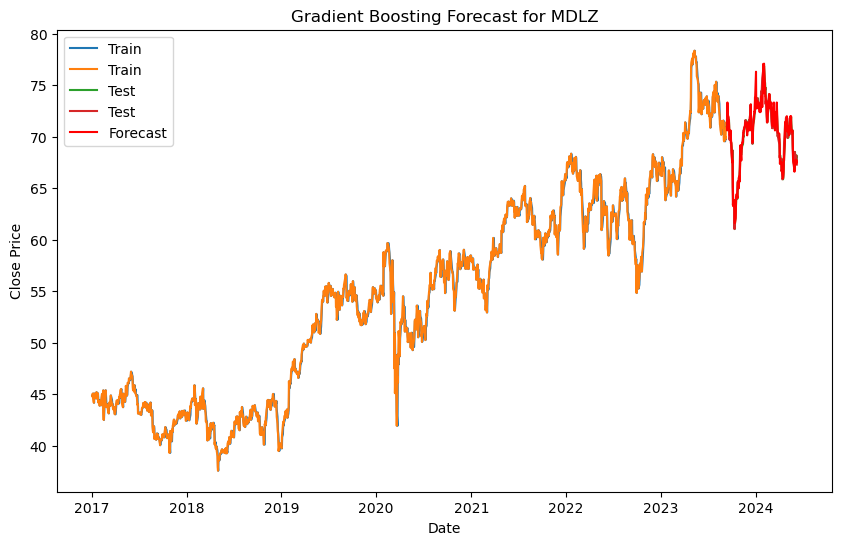

AAPL Mean Squared Error: 8.524648337611962
AAPL Root Mean Squared Error: 2.9197000424036648


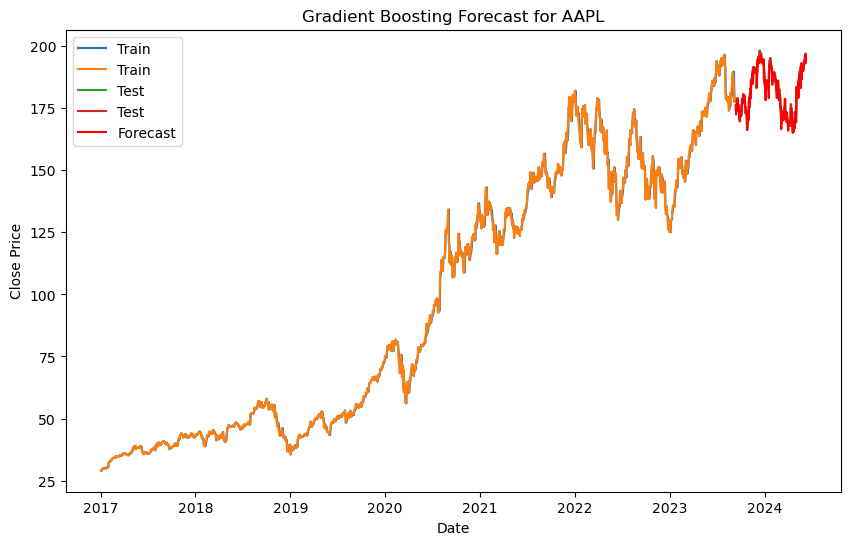

In [22]:
# creating a function to iterate through each stock and plot a predictive graph
start_date = '2017-01-01'
end_date= datetime.now()

#  getting data from df 
def get_stock_data(ticker):
    stock_data = stock_data_df[[ticker]].copy()
    return stock_data

# splitting 90-10 for model learn better based on the stocks distribution
def split(stock_data):
    split_index = int(len(stock_data) * 0.9)
    train_stocks = stock_data.iloc[:split_index]
    test_stocks = stock_data.iloc[split_index:]
    return test_stocks, train_stocks

# training ML model
def train_model(test_stocks, train_stocks):
    train_stocks['Target'] = train_stocks.shift(-1)
    test_stocks['Target'] = test_stocks.shift(-1)
    train_stocks.dropna(inplace=True)
    test_stocks.dropna(inplace=True)

    X_train_stocks = train_stocks.drop(columns=['Target'])
    y_train_stocks = train_stocks['Target']
    X_test_stocks = test_stocks.drop(columns=['Target'])
    y_test_stocks = test_stocks['Target']

    #  Gradient boosting model , using decision trees 
    gbm = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1)
    gbm.fit(X_train_stocks, y_train_stocks)

    return gbm, y_test_stocks, X_test_stocks, y_train_stocks, X_train_stocks

def test_model(gbm, X_test_stocks, y_test_stocks, train_stocks, test_stocks, ticker):
    y_pred_stocks = gbm.predict(X_test_stocks)
    mse = mean_squared_error(y_test_stocks, y_pred_stocks)
    rmse = np.sqrt(mse)
    print(f"{ticker} Mean Squared Error: {mse}")
    print(f"{ticker} Root Mean Squared Error: {rmse}")

    #  plotting a line graph
    plt.figure(figsize=(10, 6))
    plt.plot(train_stocks.index, train_stocks, label='Train')
    plt.plot(test_stocks.index, test_stocks, label='Test')
    plt.plot(test_stocks.index, y_pred_stocks, label='Forecast', color='red')
    plt.title(f'Gradient Boosting Forecast for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

# Iterate through the list of tickers
for ticker in tickers:
    stock_data = get_stock_data(ticker)
    test_stocks, train_stocks = split(stock_data)
    gbm, y_test_stocks, X_test_stocks, y_train_stocks, X_train_stocks = train_model(test_stocks, train_stocks)
    test_model(gbm, X_test_stocks, y_test_stocks, train_stocks, test_stocks, ticker)


SHOP Mean Squared Error: 6.781056565224966
SHOP Root Mean Squared Error: 2.604046191069768


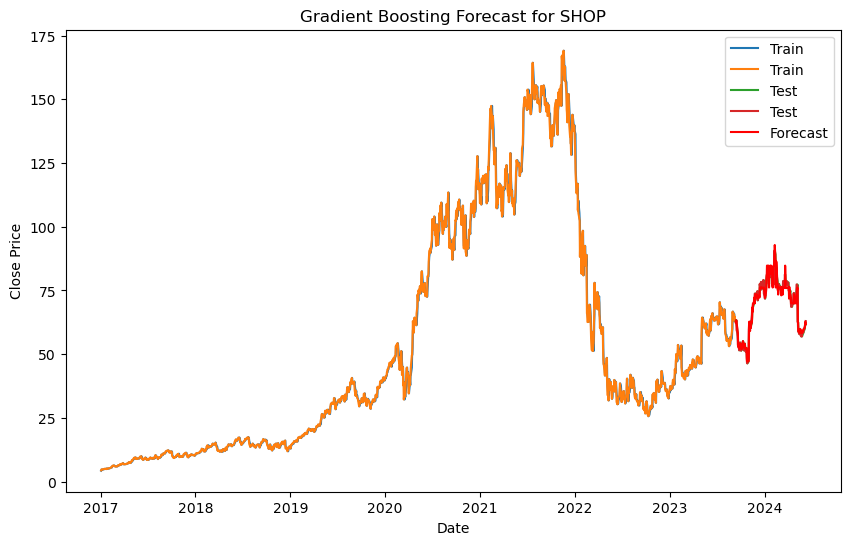

KO Mean Squared Error: 0.29012109870590036
KO Root Mean Squared Error: 0.5386289063036818


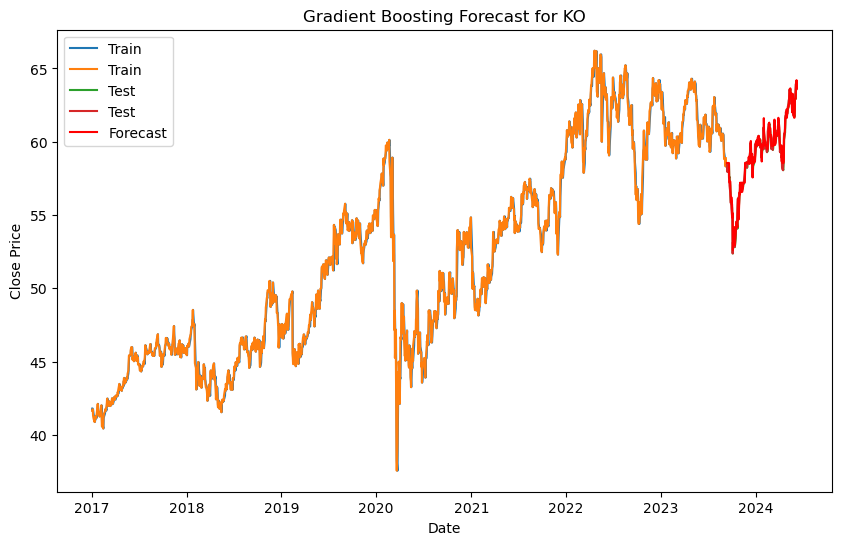

MDLZ Mean Squared Error: 0.7842193656394982
MDLZ Root Mean Squared Error: 0.8855616103013376


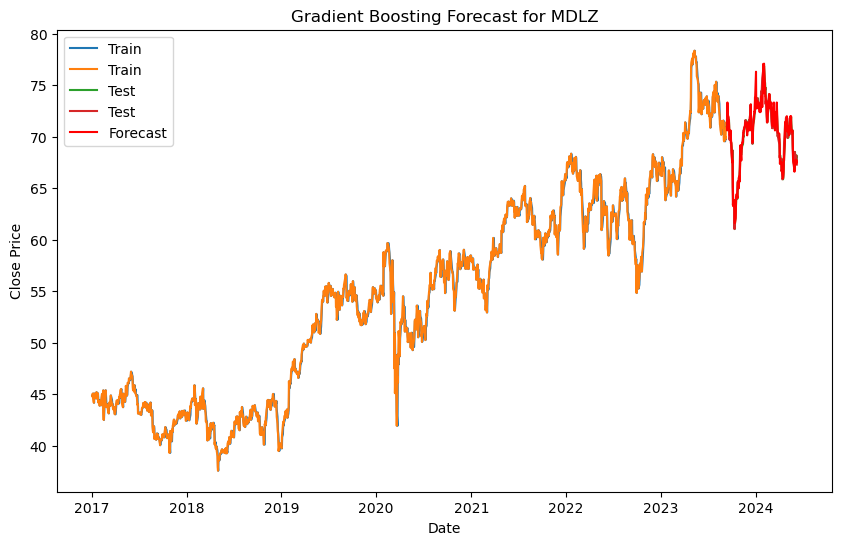

AAPL Mean Squared Error: 8.524648337611962
AAPL Root Mean Squared Error: 2.9197000424036648


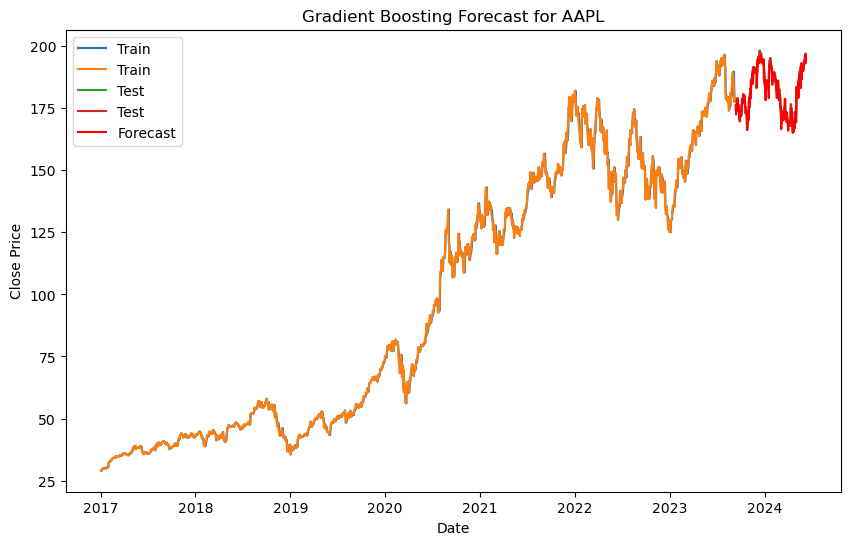

In [23]:
# creating a function to iterate through each stock and plot a predictive graph
start_date = '2017-01-01'
end_date= datetime.now()

#  getting data from df 
def get_stock_data(ticker):
    stock_data = stock_data_df[[ticker]].copy()
    return stock_data

# splitting 90-10 for model learn better based on the stocks distribution
def split(stock_data):
    split_index = int(len(stock_data) * 0.9)
    train_stocks = stock_data[:split_index]
    test_stocks = stock_data[split_index:]
    return test_stocks, train_stocks

# training ML model
def train_model(test_stocks, train_stocks):
    train_stocks['Target'] = train_stocks.shift(-1)
    test_stocks['Target'] = test_stocks.shift(-1)
    train_stocks.dropna(inplace=True)
    test_stocks.dropna(inplace=True)

    X_train_stocks = train_stocks.drop(columns=['Target'])
    y_train_stocks = train_stocks['Target']
    X_test_stocks = test_stocks.drop(columns=['Target'])
    y_test_stocks = test_stocks['Target']

    gbm = GradientBoostingRegressor(n_estimators=300, learning_rate=0.1)
    gbm.fit(X_train_stocks, y_train_stocks)

    return gbm, y_test_stocks, X_test_stocks, y_train_stocks, X_train_stocks

def test_model(gbm, X_test_stocks, y_test_stocks, train_stocks, test_stocks, ticker):
    y_pred_stocks = gbm.predict(X_test_stocks)
    mse = mean_squared_error(y_test_stocks, y_pred_stocks)
    rmse = np.sqrt(mse)
    print(f"{ticker} Mean Squared Error: {mse}")
    print(f"{ticker} Root Mean Squared Error: {rmse}")

    #  plotting a line graph
    plt.figure(figsize=(10, 6))
    plt.plot(train_stocks.index, train_stocks, label='Train')
    plt.plot(test_stocks.index, test_stocks, label='Test')
    plt.plot(test_stocks.index, y_pred_stocks, label='Forecast', color='red')
    plt.title(f'Gradient Boosting Forecast for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

# Iterate through the list of tickers
for ticker in tickers:
    stock_data = get_stock_data(ticker)
    test_stocks, train_stocks = split(stock_data)
    gbm, y_test_stocks, X_test_stocks, y_train_stocks, X_train_stocks = train_model(test_stocks, train_stocks)
    test_model(gbm, X_test_stocks, y_test_stocks, train_stocks, test_stocks, ticker)

SHOP Mean Squared Error: 6.821638692414551
SHOP Root Mean Squared Error: 2.61182669647405


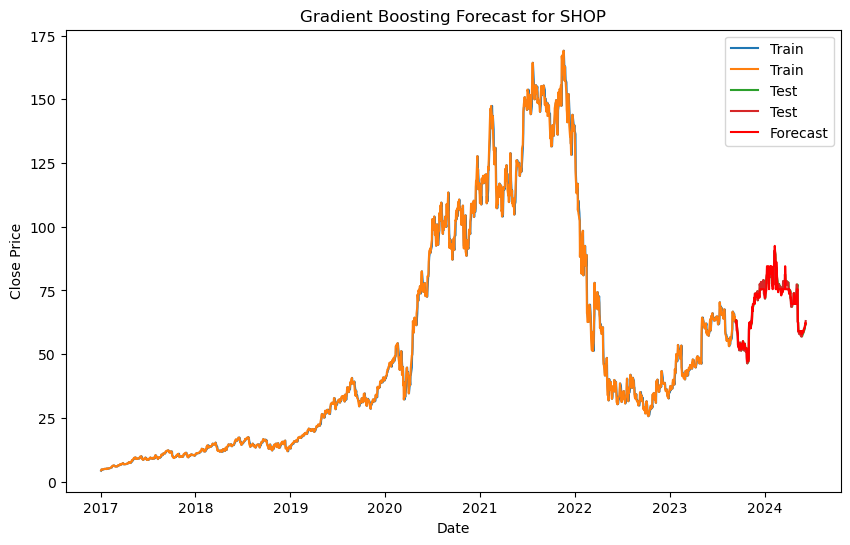

KO Mean Squared Error: 0.2639384183770542
KO Root Mean Squared Error: 0.5137493731159719


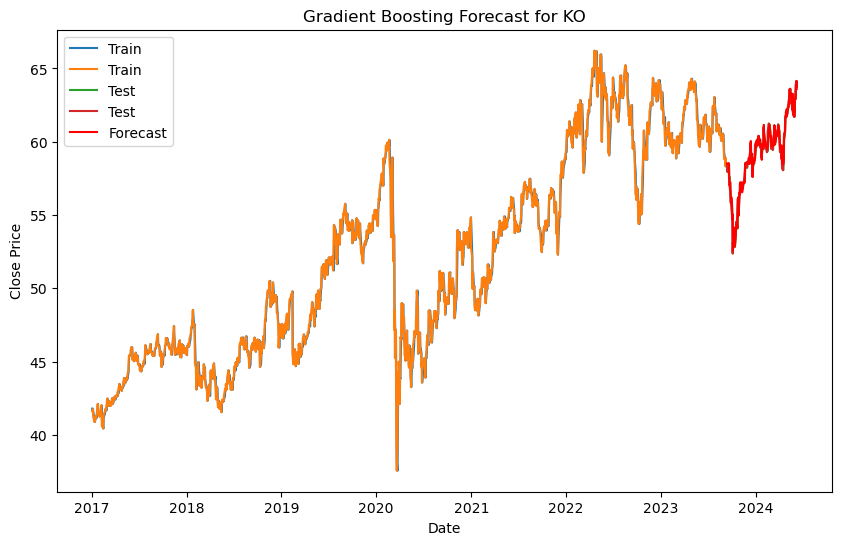

MDLZ Mean Squared Error: 0.6695232206541942
MDLZ Root Mean Squared Error: 0.8182439860177367


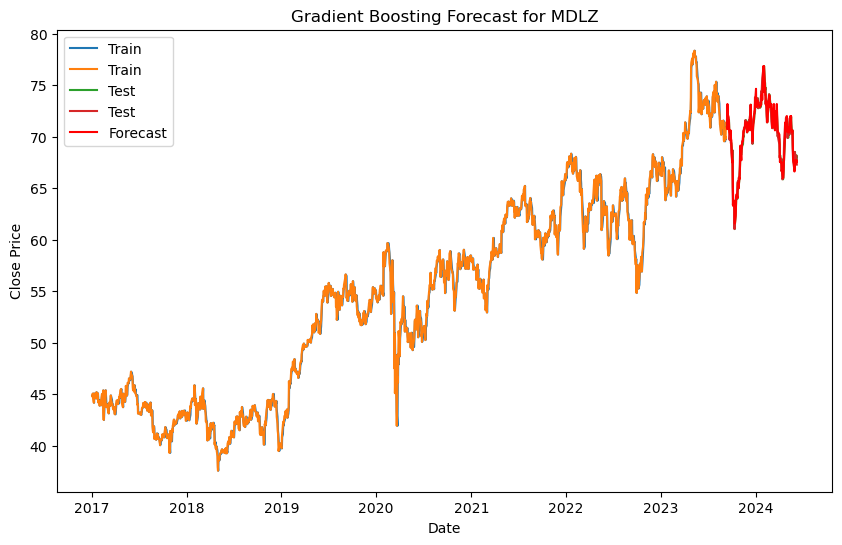

AAPL Mean Squared Error: 6.813936923346379
AAPL Root Mean Squared Error: 2.610351877304357


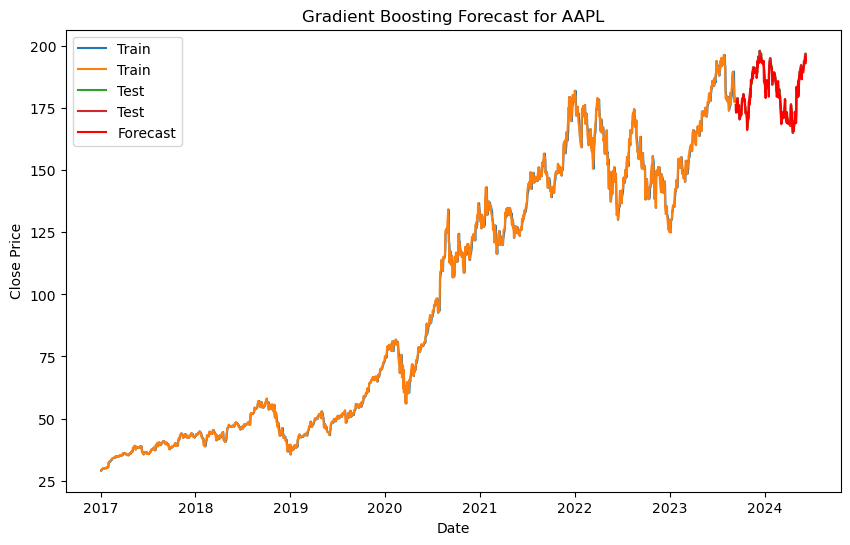

Prediction and test data for all tickers saved to all_stocks_predictions.json


In [24]:
# creating a function to iterate through each stock and plot a predictive graph
start_date = '2017-01-01'
end_date= datetime.now()

# training ML model
def train_model_2(test_stocks, train_stocks):
    train_stocks['Target'] = train_stocks.shift(-1)
    test_stocks['Target'] = test_stocks.shift(-1)
    train_stocks.dropna(inplace=True)
    test_stocks.dropna(inplace=True)

    X_train_stocks = train_stocks.drop(columns=['Target'])
    y_train_stocks = train_stocks['Target']
    X_test_stocks = test_stocks.drop(columns=['Target'])
    y_test_stocks = test_stocks['Target']

    gbm_model_2 = GradientBoostingRegressor(n_estimators=1000, learning_rate=0.01)
    gbm_model_2.fit(X_train_stocks, y_train_stocks)

    return gbm_model_2, y_test_stocks, X_test_stocks, y_train_stocks, X_train_stocks

def test_model_2(gbm_model_2, X_test_stocks, y_test_stocks, train_stocks, test_stocks, ticker):
    y_pred_stocks = gbm_model_2.predict(X_test_stocks)
    mse = mean_squared_error(y_test_stocks, y_pred_stocks)
    rmse = np.sqrt(mse)
    print(f"{ticker} Mean Squared Error: {mse}")
    print(f"{ticker} Root Mean Squared Error: {rmse}")

    #  plotting a line graph
    plt.figure(figsize=(10, 6))
    plt.plot(train_stocks.index, train_stocks, label='Train')
    plt.plot(test_stocks.index, test_stocks, label='Test')
    plt.plot(test_stocks.index, y_pred_stocks, label='Forecast', color='red')
    plt.title(f'Gradient Boosting Forecast for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.legend()
    plt.show()

    # Convert index to datetime since tolist cannot be used on df index 
    if not isinstance(train_stocks.index, pd.DatetimeIndex):
        train_stocks.index = pd.to_datetime(train_stocks.index)
    if not isinstance(test_stocks.index, pd.DatetimeIndex):
        test_stocks.index = pd.to_datetime(test_stocks.index)

    # Create dictionaries
    train_data = {
        "dates": train_stocks.index.strftime('%Y-%m-%d').tolist(),
        "prices": train_stocks.values.tolist()
    }
    test_data = {
        "dates": test_stocks.index.strftime('%Y-%m-%d').tolist(),
        "prices": test_stocks.values.tolist()
    }
    forecast_data = {
        "dates": test_stocks.index.strftime('%Y-%m-%d').tolist(),
        "prices": y_pred_stocks.tolist()
    }

    prediction = {
        "train": train_data,
        "test": test_data,
        "forecast": forecast_data
    }

    return prediction

all_predictions = {}

# Iterate through the list of tickers
for ticker in tickers:
    stock_data = get_stock_data(ticker)
    test_stocks, train_stocks = split(stock_data)
    gbm_model_2, y_test_stocks, X_test_stocks, y_train_stocks, X_train_stocks = train_model_2(test_stocks, train_stocks)
    all_predictions[ticker] = test_model_2(gbm_model_2, X_test_stocks, y_test_stocks, train_stocks, test_stocks, ticker)

# Export the data for all tickers to a single JSON file
with open("Output/prediction.json", 'w') as json_file:
    json.dump(all_predictions, json_file, indent=4)

print("Prediction and test data for all tickers saved to all_stocks_predictions.json")

Predicting future stock prices using GB_model_2 

SHOP Mean Squared Error for 90 days: 2.11763782397334
SHOP Root Mean Squared Error: 1.4552105771926411


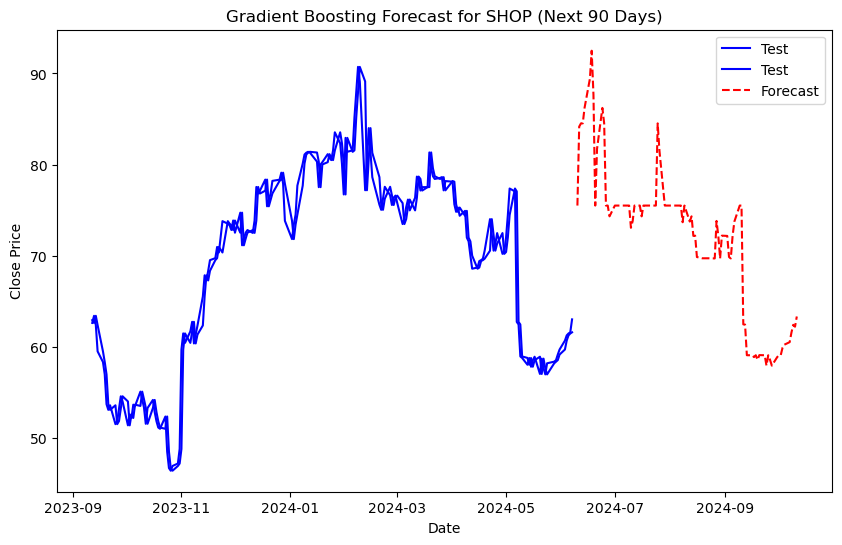

KO Mean Squared Error for 90 days: 0.0205034967356049
KO Root Mean Squared Error: 0.14319042124250106


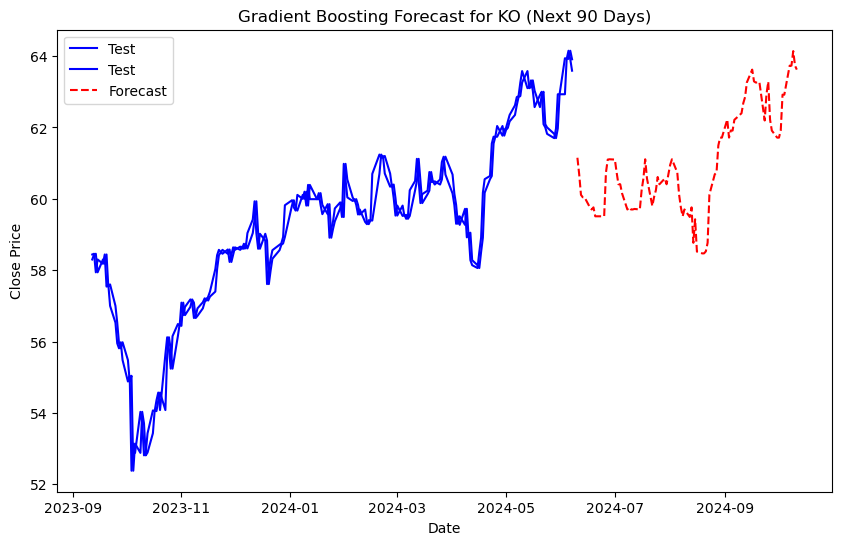

MDLZ Mean Squared Error for 90 days: 0.1017853067710477
MDLZ Root Mean Squared Error: 0.3190380961124356


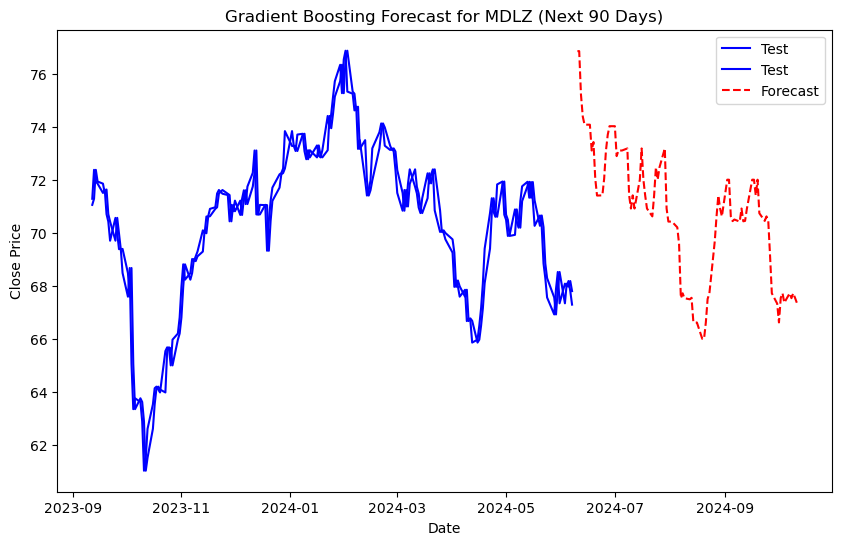

AAPL Mean Squared Error for 90 days: 1.572554232368564
AAPL Root Mean Squared Error: 1.2540152440734378


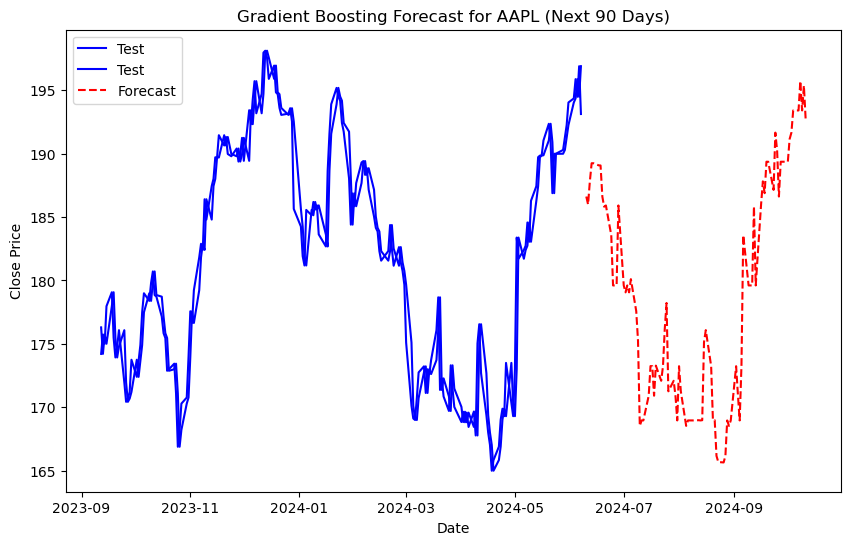

Prediction and test data for all tickers saved to all_stocks_prediction_and_test_data.json


In [25]:
def prediction_model_to_json(gbm_model_2, stock_data, train_stocks, test_stocks, ticker, all_predictions):
    # define start date 
    start_date_future = test_stocks.index[-1] + pd.Timedelta(days=1)

    # Predict the future prices for the next 90 days
    future_dates = pd.date_range(start=start_date_future, periods=90, freq='B')
    future_prices = gbm_model_2.predict(stock_data[[ticker]][-90:])

    # Creating a DataFrame
    forecast_df = pd.DataFrame(future_prices, index=future_dates)

    mse = mean_squared_error(test_stocks['Target'][-90:], forecast_df)
    rmse = np.sqrt(mse)
    print(f"{ticker} Mean Squared Error for 90 days: {mse}")
    print(f"{ticker} Root Mean Squared Error: {rmse}")

    #  plotting a line graph
    plt.figure(figsize=(10, 6))
    plt.plot(test_stocks.index, test_stocks, label='Test', color='blue')
    plt.plot(forecast_df.index, forecast_df, label='Forecast', color='red', linestyle='--')
    plt.title(f'Gradient Boosting Forecast for {ticker} (Next 90 Days)')
    plt.xlabel('Date')
    plt.ylabel('Close Price')
    plt.savefig('Output/Gradient Boosting Forecast for {ticker} (Next 90 Days).png')
    plt.legend()
    plt.show()

    # Convert index to datetime since tolist cannot be used on df index 
    if not isinstance(forecast_df.index, pd.DatetimeIndex):
        forecast_df.index = pd.to_datetime(forecast_df.index)
    if not isinstance(test_stocks.index, pd.DatetimeIndex):
        test_stocks.index = pd.to_datetime(test_stocks.index)

    # Creating dictionaries
    test_data = {
        "dates": test_stocks.index.strftime('%Y-%m-%d').tolist(),
        "prices": test_stocks.values.tolist()
    }
    forecast_data = {
        "dates": forecast_df.index.strftime('%Y-%m-%d').tolist(),
        "prices": forecast_df.squeeze().values.tolist()
    }

    # Combine test and forecast data
    prediction_and_test_data = {
        "test": test_data,
        "forecast": forecast_data
    }

    all_predictions[ticker] = prediction_and_test_data

# empty dictionary
all_predictions = {}

# Iterate through the list of tickers
for ticker in tickers:
    stock_data = get_stock_data(ticker)
    test_stocks, train_stocks = split(stock_data)
    gbm_model_2, y_test_stocks, X_test_stocks, y_train_stocks, X_train_stocks = train_model_2(test_stocks, train_stocks)
    prediction_model_to_json(gbm_model_2, stock_data, train_stocks, test_stocks, ticker, all_predictions)

# Export the data for all tickers to a single JSON file
with open("Output/all_stocks_prediction_and_test_datas.json", 'w') as json_file:
    json.dump(all_predictions, json_file, indent=4)

print("Prediction and test data for all tickers saved to all_stocks_prediction_and_test_data.json")